## Gradient boosting

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lolviz as lv

In [3]:
class DecisionNode:
    def __init__(self, split) -> None:
        self.left = None
        self.right = None
        self.split = split
    def predict(self, x):
        if x < self.split:
            return self.left.predict(x)
        return self.right.predict(x)
    def predict_list(self, x_list):
        return np.array([self.predict(x_val) for x_val in x_list])
    
class LeafNode:
    def __init__(self, y) -> None:
        self.y = y
        self.w = 0
    def predict(self, x):
        return self.w

In [4]:
def fit(x, y):
    loss, split = find_best_split(x, y)
    root = DecisionNode(split)
    root.left = LeafNode(y[x < split])
    root.right = LeafNode(y[x >= split])
    return root
        
def find_best_split(x,y):
    best_loss = np.inf
    best_split = -1
    print(f"find_best_split in x={list(x)}")
    for v in x[1:]:
        lefty = y[x<v]
        righty = y[x>=v]
        nl = len(lefty)
        nr = len(righty)
        if nl==0 or nr==0:
            continue
        loss = np.var(lefty)*nl + np.var(righty)*nr
        print(f"{lefty} | {righty}              candidate split x={v} loss {loss:8.1f}")
        if loss < best_loss:
            best_loss = loss
            best_split = v
    return float(best_loss), best_split

In [5]:
df = pd.DataFrame()
df["sqfeet"] = [750, 800, 850, 900,950]
df["rent"] = [1160, 1200, 1280, 1450,2000]
df

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,2000


In [6]:
X = df["sqfeet"].values
y = df["rent"].values
print(X)
print(y)

[750 800 850 900 950]
[1160 1200 1280 1450 2000]


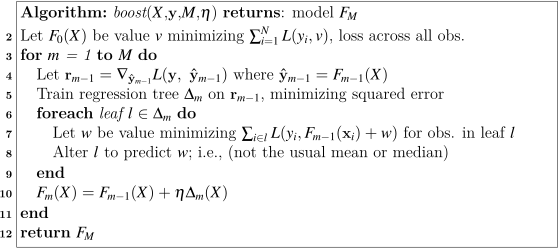

In [11]:
# def calculate_f(X, f, eta):
#     res = np.array([])
#     for v in X:
#         ret = f[0].predict(X)
#         for i in range(1, len(f)):
#             ret += eta * f[i].predict(v)
#         res = np.append(res, ret)
#     return res
def calculate_f(X, f, eta):
    ret = f[0]
    for i in range(1, len(f)):
        ret += eta * f[i].predict_list(X)
    return ret

def gradient_boost(X, y, M, eta):
    f_0 = np.mean(y)
    f = np.array([f_0])
    for _ in range(1, M + 1):
        r = y - calculate_f(X, f, eta)
        t = fit(X, r)
        t.left.w = np.mean(y[X < t.split] - calculate_f(X[X < t.split], f, eta))
        t.right.w = np.mean(y[X >= t.split] - calculate_f(X[X >= t.split], f, eta))
        f = np.append(f, t)
    return f

def predict_gradient_boost(v, f, eta):
    ret = f[0]
    for i in range(1, len(f)):
        ret += eta * f[i].predict(v)
    return ret

In [23]:
M = 3
eta = 0.8
f = gradient_boost(X, y, M, eta)

find_best_split in x=[750, 800, 850, 900, 950]
[-258.] | [-218. -138.   32.  582.]              candidate split x=800 loss 389675.0
[-258. -218.] | [-138.   32.  582.]              candidate split x=850 loss 284066.7
[-258. -218. -138.] | [ 32. 582.]              candidate split x=900 loss 158716.7
[-258. -218. -138.   32.] | [582.]              candidate split x=950 loss  49475.0
find_best_split in x=[750, 800, 850, 900, 950]
[-141.6] | [-101.6  -21.6  148.4  116.4]              candidate split x=800 loss  41348.0
[-141.6 -101.6] | [-21.6 148.4 116.4]              candidate split x=850 loss  17122.7
[-141.6 -101.6  -21.6] | [148.4 116.4]              candidate split x=900 loss   7978.7
[-141.6 -101.6  -21.6  148.4] | [116.4]              candidate split x=950 loss  49475.0
find_best_split in x=[750, 800, 850, 900, 950]
[-70.98666667] | [-30.98666667  49.01333333  42.48        10.48      ]              candidate split x=800 loss   4017.1
[-70.98666667 -30.98666667] | [49.01333333 42.48

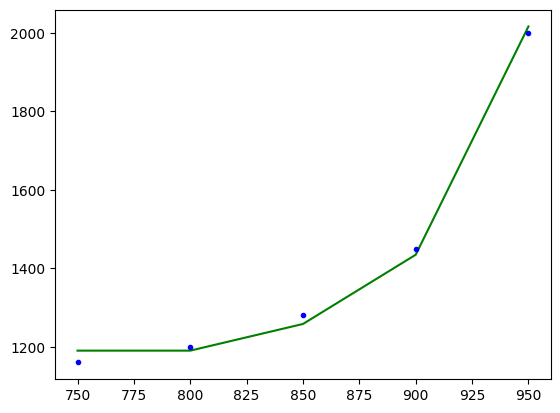

In [24]:
y_predicted = np.array([predict_gradient_boost(x, f, eta) for x in X])
plt.plot(X, y_predicted, "g-")
plt.plot(X, y, "b.")

In [10]:
def mse(X, y, f, eta):
    y_predicted = np.array([predict_gradient_boost(x, f, eta) for x in X])
    N = len(y)
    return np.sum((y - y_predicted) ** 2) / N

def effect_of_learning_rate(X, y):
    mse_min = np.inf
    M_min = np.inf
    eta_min = np.inf
    for eta in range(1, 10):
        for M in range(1, 4):
            f = gradient_boost(X, y, M, eta / 10)
            current_mse = mse(X, y, f, eta / 10)
            if current_mse < mse_min:
                mse_min = current_mse
                M_min = M
                eta_min = eta / 10
    print(f"MSE min: {mse_min}")
    print(f"Number of stages min: {M_min}")
    print(f"Eta min: {eta_min}")

In [11]:
effect_of_learning_rate(X, y)

MSE min: 399.42388622222086
Number of stages min: 3
Eta min: 0.8
